In [1]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, kpss

import pmdarima as pm

In [2]:
import sys
sys.path.append('..')
sys.path.append('../utils')

In [3]:
from sdafe.ch13.timeseries import plot_accf

In [4]:
from ch13.utils import predict, refit

In [5]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri, numpy2ri, default_converter

np_cv_rules = default_converter + numpy2ri.converter

In [6]:
rstats = importr('stats')
MTS = importr('MTS')
fracdiff = importr('fracdiff')

### 13.8.1 Seasonal ARIMA Models

In [7]:
data = pd.read_csv('../data/IncomeUK.csv')
data.head()

,income,consumption
0,9014,8016
1,9659,8798
2,9848,9184
3,10316,9755
4,10254,9113


#### Problem 1

In [8]:
log_cons = np.log(data['consumption'])

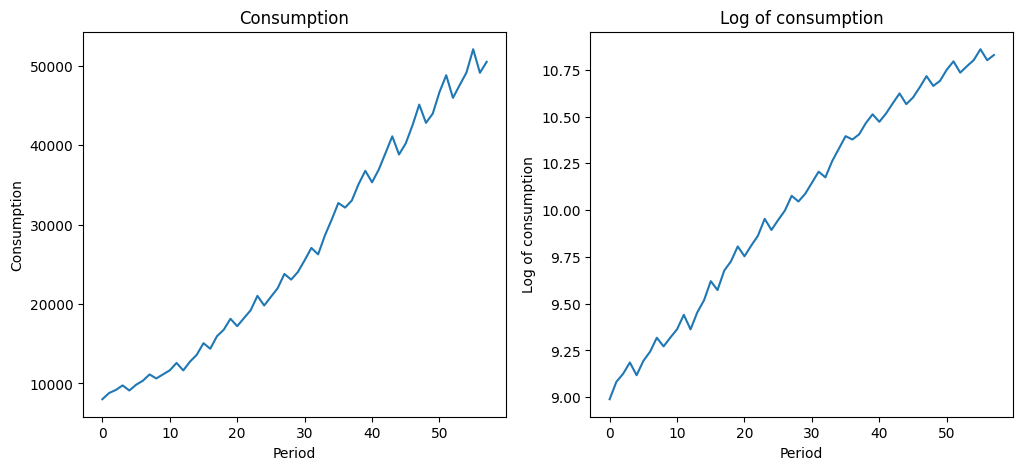

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(data['consumption']);
axs[0].set_title('Consumption');
axs[0].set_xlabel('Period');
axs[0].set_ylabel('Consumption');

axs[1].plot(log_cons);
axs[1].set_title('Log of consumption');
axs[1].set_xlabel('Period');
axs[1].set_ylabel('Log of consumption');

The features of the time series:
   * seasonality,
   * seasonal fluctuations increase with the level,
   * growing trend.

Therefore, a variance stabilising transformation (such as logarithm) might be useful and both seasonal and nonseasonal differencing should be attempted.

In [10]:
diff_cons  = log_cons.diff().dropna()
diff_season = diff_cons.diff(periods=4).dropna();

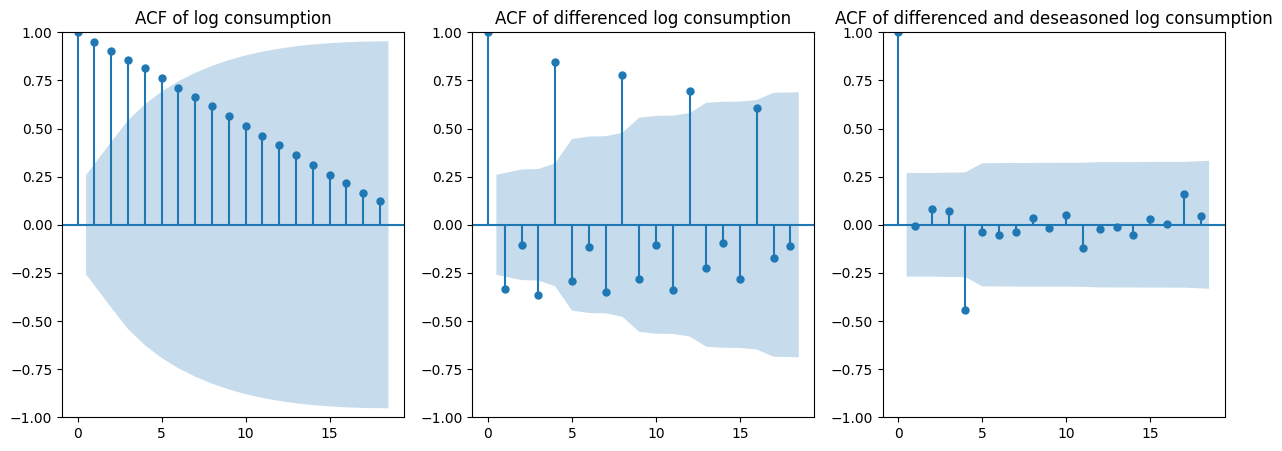

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

plot_acf(log_cons, ax=axs[0]);
axs[0].set_title('ACF of log consumption');

plot_acf(diff_cons, ax=axs[1]);
axs[1].set_title('ACF of differenced log consumption');

plot_acf(diff_season, ax=axs[2]);
axs[2].set_title('ACF of differenced and deseasoned log consumption');

#### Problem 2

By default, `auto_arima` assumes the period of seasonal differencing to be 1, which gives suboptimal results:

In [12]:
pm.auto_arima(log_cons).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   58
Model:               SARIMAX(3, 2, 2)   Log Likelihood                 138.922
Date:                Fri, 19 May 2023   AIC                           -265.845
Time:                        12:35:25   BIC                           -253.693
Sample:                             0   HQIC                          -261.133
                                 - 58                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9586      0.031    -31.162      0.000      -1.019      -0.898
ar.L2         -0.9712      0.022    -44.585      0.000      -1.014      -0.928
ar.L3         -0.9704      0.026    -37.088      0.000      -1.022      -0.919
ma.L1         -0.0521      0.174     -0.299      0.765      -0.393       0.289
ma.L2          0.5867      0.103      5.688      0.000       0.385       0.789
sigma2         0.0004   7.12e-05      5.083      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 2.49
Prob(Q):                              0.83   Prob(JB):                         0.29
Heteroskedasticity (H):               0.30   Skew:                             0.40
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Providing the expected period of seasonality results in a more parsimonious model:

In [13]:
fit = pm.auto_arima(log_cons, m=4)
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   58
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 4)   Log Likelihood                 139.767
Date:                             Fri, 19 May 2023   AIC                           -275.535
Time:                                     12:35:41   BIC                           -271.594
Sample:                                          0   HQIC                          -274.019
                                              - 58                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L4       -0.5455      0.131     -4.177      0.000      -0.801      -0.290
sigma2         0.0003   6.82e-05      4.283      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.41
Prob(Q):                              0.88   Prob(JB):                         0.81
Heteroskedasticity (H):               0.35   Skew:                             0.01
Prob(H) (two-sided):                  0.03   Kurtosis:                         2.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The selected model is SARIMAX(0, 1, 0)x(0, 1, [1], 4).

#### Problem 3

Note that we have to skip the first few residual values due to the estimation method used:

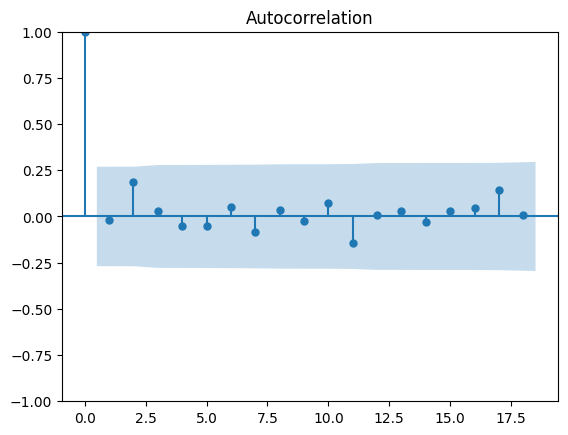

In [14]:
plot_acf(fit.resid()[fit.arima_res_.loglikelihood_burn:]);

Alternatively, we could use the `plot_diagnostics()` function to display these results:

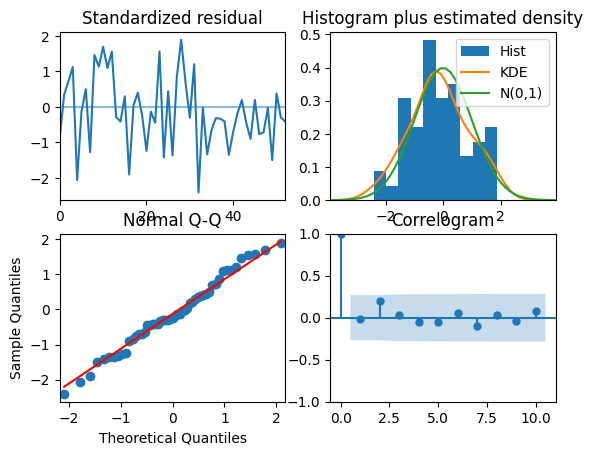

In [15]:
fit.plot_diagnostics();

#### Problem 5

The result of `auto_arima` does not have a `get_prediction()` function, so cannot show confidence intervals, hence we fit an ARIMA model directly.

In [16]:
model = ARIMA(log_cons, order=(0, 1, 0), seasonal_order=(0, 1, 1, 4)).fit(method='innovations_mle')
model.summary()

/tmp/ipykernel_24481/3070434235.py:1: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
  model = ARIMA(log_cons, order=(0, 1, 0), seasonal_order=(0, 1, 1, 4)).fit(method='innovations_mle')


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                       consumption   No. Observations:                   58
Model:             ARIMA(0, 1, 0)x(0, 1, [1], 4)   Log Likelihood                 139.772
Date:                           Fri, 19 May 2023   AIC                           -275.543
Time:                                   12:35:43   BIC                           -271.603
Sample:                                        0   HQIC                          -274.028
                                            - 58                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L4       -0.5348      0.132     -4.060      0.000      -0.793      -0.277
sigma2         0.0003   6.85e-05      4.268      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.38
Prob(Q):                              0.89   Prob(JB):                         0.83
Heteroskedasticity (H):               0.35   Skew:                             0.00
Prob(H) (two-sided):                  0.03   Kurtosis:                         2.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
def plot_forecast(ax, model, start, end, alphas):
    if type(alphas) is float:
        alphas = [alphas]
    else:
        alphas = sorted(alphas, reverse=False)
    fcst = model.get_prediction(start=start, end=end).summary_frame()
    ax.plot(fcst.index, fcst['mean']);
    for alpha in alphas:
        fcst = model.get_prediction(start=start, end=end).summary_frame(alpha=alpha)
        ax.fill_between(
            fcst.index, fcst['mean_ci_lower'], fcst['mean_ci_upper'], alpha=0.25, label=f'{round((1-alpha)*100)}% interval'
        )
    ax.legend(loc='upper left')

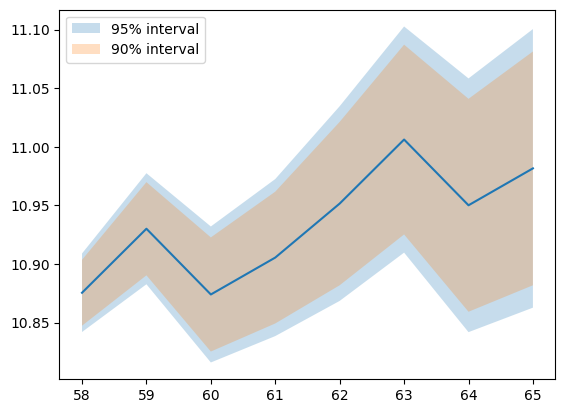

In [18]:
fig, ax = plt.subplots()
plot_forecast(ax, model, 58, 65, [0.05, 0.1]);

### 13.8.2 Regression with HAC Standard Errors

In [19]:
data = pd.read_csv('../data/Mishkin.csv', usecols=list(range(1, 7)), index_col=0)
data.head()

,pai1,pai3,tb1,tb3,cpi
Year,,,,,
1950.083333,-3.552289,1.129370,1.100854,1.129406,23.5
1950.166667,5.247540,4.001566,1.125513,1.137254,23.6
1950.250000,1.692860,4.492160,1.115715,1.142319,23.6
1950.333333,5.064298,7.817513,1.146380,1.177902,23.7
1950.416667,6.719322,9.433580,1.158520,1.167777,23.8


In [20]:
tb1_diff = data['tb1'].diff().dropna()
tb3_diff = data['tb3'].diff().dropna()

In [21]:
model = sm.OLS(tb1_diff, sm.add_constant(tb3_diff)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    tb1   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     653.1
Date:                Fri, 19 May 2023   Prob (F-statistic):           4.63e-92
Time:                        12:35:44   Log-Likelihood:                -311.73
No. Observations:                 490   AIC:                             627.5
Df Residuals:                     488   BIC:                             635.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.409e-06      0.021      0.000      1.000      -0.041       0.041
tb3            0.9447      0.037     25.556      0.000       0.872       1.017
==============================================================================
Omnibus:                       59.563   Durbin-Watson:                   2.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              467.864
Skew:                          -0.009   Prob(JB):                    2.54e-102
Kurtosis:                       7.787   Cond. No.                         1.79
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Problem 6

There is evidence of autocorrelation in the residuals.

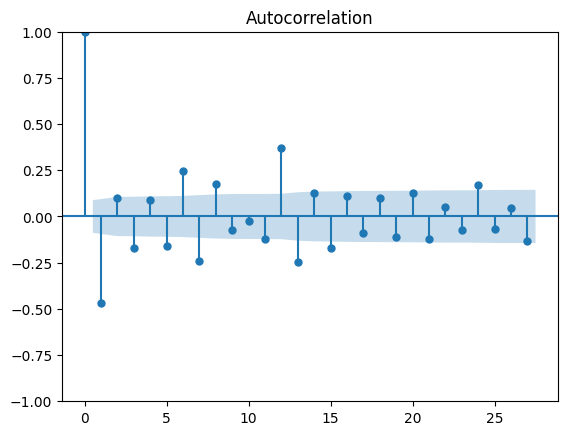

In [22]:
plot_acf(model.resid);

The Ljung-Box test confirms the conclusion with high confidence:

In [23]:
acorr_ljungbox(model.resid, lags=[24])

,lb_stat,lb_pvalue
24,408.59308,1.290524e-71


#### Problem 7

Using the HC standard error estimates results in a lower value $t$ for the regression coefficient, but does not change the conclusion of the hypothesis tests.

In [24]:
model.get_robustcov_results(cov_type='HAC', maxlags=0).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    tb1   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     138.9
Date:                Fri, 19 May 2023   Prob (F-statistic):           2.22e-28
Time:                        12:35:44   Log-Likelihood:                -311.73
No. Observations:                 490   AIC:                             627.5
Df Residuals:                     488   BIC:                             635.8
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.409e-06      0.021      0.000      1.000      -0.041       0.041
tb3            0.9447      0.080     11.784      0.000       0.787       1.102
==============================================================================
Omnibus:                       59.563   Durbin-Watson:                   2.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              467.864
Skew:                          -0.009   Prob(JB):                    2.54e-102
Kurtosis:                       7.787   Cond. No.                         1.79
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 0 lags and without small sample correction
"""

#### Problem 8

The $t$ value slighly increases when using higher values of `maxlags`:

In [25]:
model.get_robustcov_results(cov_type='HAC', maxlags=1).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    tb1   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     155.9
Date:                Fri, 19 May 2023   Prob (F-statistic):           3.02e-31
Time:                        12:35:45   Log-Likelihood:                -311.73
No. Observations:                 490   AIC:                             627.5
Df Residuals:                     488   BIC:                             635.8
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.409e-06      0.015      0.000      1.000      -0.030       0.030
tb3            0.9447      0.076     12.487      0.000       0.796       1.093
==============================================================================
Omnibus:                       59.563   Durbin-Watson:                   2.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              467.864
Skew:                          -0.009   Prob(JB):                    2.54e-102
Kurtosis:                       7.787   Cond. No.                         1.79
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

In [26]:
model.get_robustcov_results(cov_type='HAC', maxlags=2).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    tb1   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     165.1
Date:                Fri, 19 May 2023   Prob (F-statistic):           9.37e-33
Time:                        12:35:45   Log-Likelihood:                -311.73
No. Observations:                 490   AIC:                             627.5
Df Residuals:                     488   BIC:                             635.8
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.409e-06      0.014      0.000      1.000      -0.027       0.027
tb3            0.9447      0.074     12.849      0.000       0.800       1.089
==============================================================================
Omnibus:                       59.563   Durbin-Watson:                   2.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              467.864
Skew:                          -0.009   Prob(JB):                    2.54e-102
Kurtosis:                       7.787   Cond. No.                         1.79
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 2 lags and without small sample correction
"""

In [27]:
model.get_robustcov_results(cov_type='HAC', maxlags=3).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    tb1   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     171.6
Date:                Fri, 19 May 2023   Prob (F-statistic):           8.28e-34
Time:                        12:35:45   Log-Likelihood:                -311.73
No. Observations:                 490   AIC:                             627.5
Df Residuals:                     488   BIC:                             635.8
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.409e-06      0.012      0.000      1.000      -0.023       0.023
tb3            0.9447      0.072     13.099      0.000       0.803       1.086
==============================================================================
Omnibus:                       59.563   Durbin-Watson:                   2.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              467.864
Skew:                          -0.009   Prob(JB):                    2.54e-102
Kurtosis:                       7.787   Cond. No.                         1.79
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 3 lags and without small sample correction
"""

### 13.8.3 Regression with ARMA Noise

In [28]:
data = pd.read_csv('../data/USMacroG.csv', index_col=0)
data.head()

,gdp,consumption,invest,government,dpi,cpi,m1,tbill,unemp,population,inflation,interest
1,1610.5,1058.9,198.1,361.0,1186.1,70.6,110.20,1.12,6.4,149.461,NaN,NaN
2,1658.8,1075.9,220.4,366.4,1178.1,71.4,111.75,1.17,5.6,150.260,4.5071,-3.3404
3,1723.0,1131.0,239.7,359.6,1196.5,73.2,112.95,1.23,4.6,151.064,9.9590,-8.7290
4,1753.9,1097.6,271.8,382.5,1210.0,74.9,113.93,1.35,4.2,151.871,9.1834,-7.8301
5,1773.5,1122.8,242.9,421.9,1207.9,77.3,115.08,1.40,3.5,152.393,12.6160,-11.2160


In [29]:
diffed = data[['unemp', 'invest', 'government']].diff().dropna()

In [30]:
fit1 = ARIMA(diffed['unemp'].values, exog=diffed[['invest', 'government']].values, order=(1, 0, 0)).fit(method='innovations_mle')
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  203
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 -38.426
Date:                Fri, 19 May 2023   AIC                             86.852
Time:                        12:35:46   BIC                            103.418
Sample:                             0   HQIC                            93.554
                                - 203                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0209      0.050      0.417      0.677      -0.077       0.119
x1            -0.0036      0.001     -5.716      0.000      -0.005      -0.002
x2            -0.0016      0.002     -0.818      0.413      -0.005       0.002
ar.L1          0.5567      0.048     11.647      0.000       0.463       0.650
sigma2         0.0853      0.007     11.431      0.000       0.071       0.100
===================================================================================
Ljung-Box (L1) (Q):                   0.54   Jarque-Bera (JB):                23.04
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               0.25   Skew:                             0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

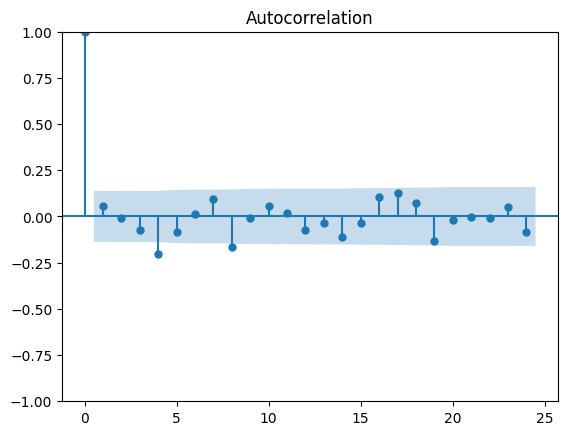

In [31]:
plot_acf(fit1.resid);

#### Problem 9

A linear regression assuming uncorrelated residuals results in a higher AIC:

In [32]:
fit2 = sm.OLS(diffed['unemp'], sm.add_constant(diffed[['invest', 'government']])).fit()
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  unemp   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     39.22
Date:                Fri, 19 May 2023   Prob (F-statistic):           4.25e-15
Time:                        12:35:46   Log-Likelihood:                -65.441
No. Observations:                 203   AIC:                             136.9
Df Residuals:                     200   BIC:                             146.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0784      0.027      2.875      0.004       0.025       0.132
invest        -0.0070      0.001     -8.497      0.000      -0.009      -0.005
government    -0.0060      0.002     -3.088      0.002      -0.010      -0.002
==============================================================================
Omnibus:                       33.173   Durbin-Watson:                   1.212
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.441
Skew:                           0.774   Prob(JB):                     8.34e-16
Kurtosis:                       5.411   Cond. No.                         34.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Residuals shows significant autocorrelation:

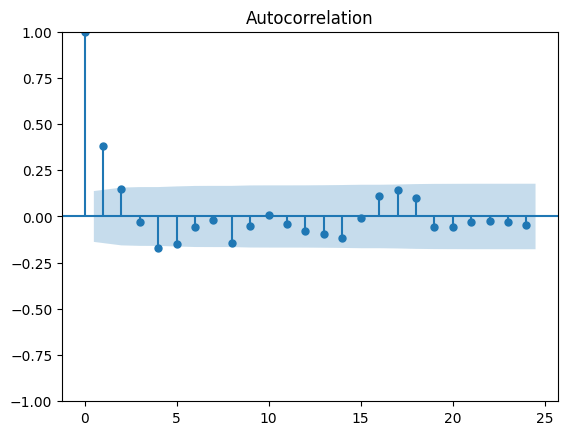

In [33]:
plot_acf(fit2.resid);

#### Problem 10

BIC is higher for the linear regression model assuming uncorrelated residuals, so the conclusion still holds.

#### Problem 11

Using AR(2) results in a marginally better AIC, but slightly worse BIC:

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  203
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 -37.140
Date:                Fri, 19 May 2023   AIC                             86.280
Time:                        12:35:48   BIC                            106.159
Sample:                             0   HQIC                            94.322
                                - 203                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0186      0.046      0.405      0.685      -0.071       0.108
x1            -0.0032      0.001     -5.074      0.000      -0.004      -0.002
x2            -0.0014      0.002     -0.755      0.4

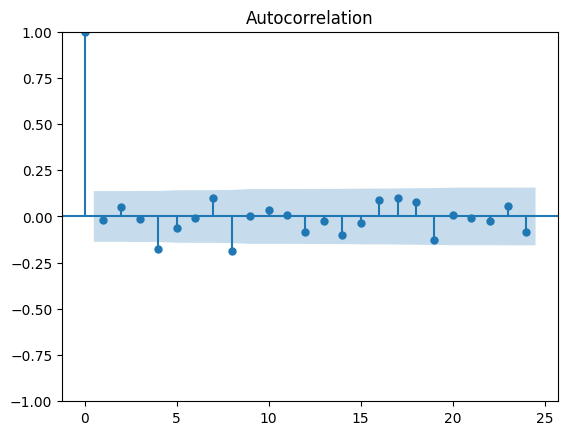

In [34]:
fit1 = ARIMA(diffed['unemp'].values, exog=diffed[['invest', 'government']].values, order=(2, 0, 0)).fit(method='innovations_mle')
print(fit1.summary())
plot_acf(fit1.resid);

Using ARMA(1, 1) results in slighly worse AIC and BIC:

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  203
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -37.599
Date:                Fri, 19 May 2023   AIC                             87.198
Time:                        12:35:50   BIC                            107.077
Sample:                             0   HQIC                            95.240
                                - 203                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0190      0.048      0.399      0.690      -0.075       0.113
x1            -0.0033      0.001     -5.166      0.000      -0.005      -0.002
x2            -0.0015      0.002     -0.768      0.4

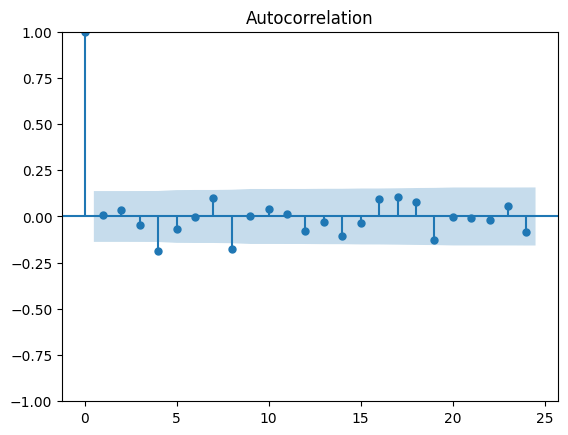

In [35]:
fit1 = ARIMA(diffed['unemp'].values, exog=diffed[['invest', 'government']].values, order=(1, 0, 1)).fit(method='innovations_mle')
print(fit1.summary())
plot_acf(fit1.resid);

### 13.8.4 VAR Models

In [36]:
data = pd.read_csv('../data/TbGdpPi.csv')
data.index = pd.date_range(start='1955', freq='Q', periods=data.shape[0])
data.head()
# r = the 91-day Treasury bill rate
# y = the log of real GDP
# pi = the inflation rate

,r,y,pi
1955-03-31,1.41,7.894976,0.000000
1955-06-30,1.47,7.911123,0.000000
1955-09-30,2.15,7.924480,0.749064
1955-12-31,2.50,7.930480,-0.371747
1956-03-31,2.30,7.926614,0.000000


In [37]:
del_dat = data.diff().dropna()

In [38]:
with np_cv_rules.context():
    fit = rstats.ar(del_dat.values, order_max=4)
fit['aic']

array([217.73844726, 126.00731346,  82.58204316,   0.        ,
        10.32957342])

In [39]:
resid = fit['resid']
resid = resid[~np.any(np.isnan(resid), axis=1)]

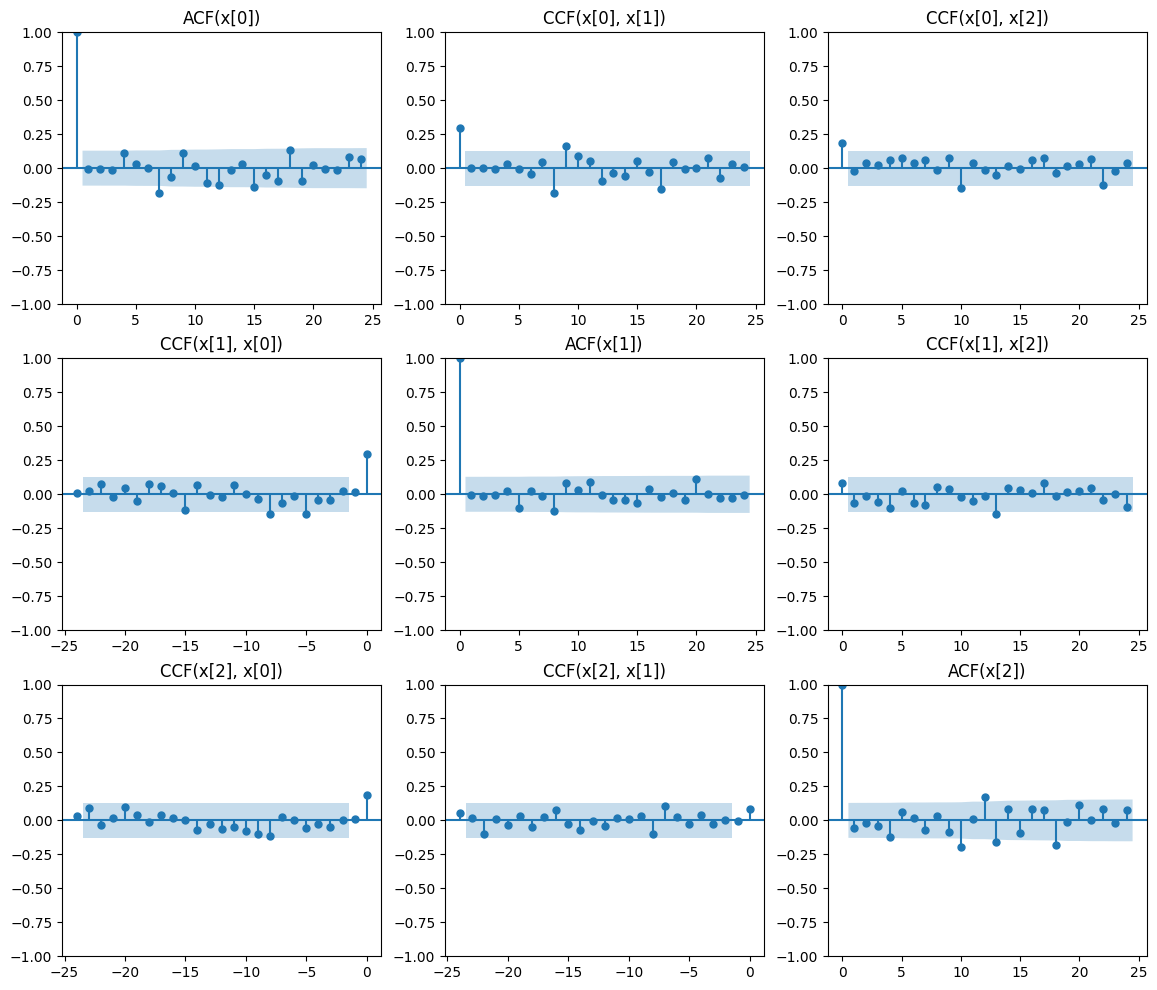

In [40]:
fig = plt.figure(figsize=(14, 12))
plot_accf(resid, fig=fig);

#### Problem 12

(a) $p$ is

In [41]:
fit['order'][0]

3

The estimates of $\Phi_1, ..., \Phi_p$ are:

In [42]:
phis = fit['ar']
phis

array([[[-1.45510616e-01,  1.62062540e+01, -9.81918691e-02],
        [ 5.16688679e-04,  2.92340442e-01,  9.49271227e-04],
        [ 1.82083074e-01,  5.02766040e+00, -8.05748486e-01]],

       [[-2.27198959e-01,  1.27946708e+01,  3.29187892e-02],
        [-1.98226121e-03,  1.78473368e-01,  3.82071518e-04],
        [ 1.65525973e-03, -3.03923986e+00, -6.85300322e-01]],

       [[ 2.27678094e-01, -2.76418265e+00,  3.02248038e-02],
        [-7.71963448e-04, -1.62513125e-02,  4.15546215e-04],
        [ 1.54093643e-01,  1.32298568e+01, -5.13555878e-01]]])

(b) The estimated covariance matrix of $\epsilon_t$ is:

In [43]:
fit['var.pred']

array([[7.37580524e-01, 2.08685366e-03, 1.08698637e-01],
       [2.08685366e-03, 6.76438911e-05, 4.95268846e-04],
       [1.08698637e-01, 4.95268846e-04, 4.61792683e-01]])

(c) Based on the ACF/CCF plots, there do appear to be significant auto- and cross-correlations, so the fit is not adequate.

We can use the mutlivariate Ljung-Box test to confirm:

In [44]:
with np_cv_rules.context():
    MTS.mq(del_dat.values, lag=20, adj=27)  # 3 matrices 3x3

Ljung-Box Statistics:  
        m       Q(m)     df    p-value
 [1,]   1.0      99.4   -18.0        1
 [2,]   2.0     138.1    -9.0        1
 [3,]   3.0     179.0     0.0        1
 [4,]   4.0     215.1     9.0        0
 [5,]   5.0     232.6    18.0        0
 [6,]   6.0     242.7    27.0        0
 [7,]   7.0     267.2    36.0        0
 [8,]   8.0     315.1    45.0        0
 [9,]   9.0     338.4    54.0        0
[10,]  10.0     346.6    63.0        0
[11,]  11.0     358.2    72.0        0
[12,]  12.0     404.8    81.0        0
[13,]  13.0     421.2    90.0        0
[14,]  14.0     427.1    99.0        0
[15,]  15.0     440.5   108.0        0
[16,]  16.0     473.6   117.0        0
[17,]  17.0     485.9   126.0        0
[18,]  18.0     496.5   135.0        0
[19,]  19.0     510.0   144.0        0
[20,]  20.0     539.8   153.0        0


#### Problem 13

In [45]:
v = del_dat.values

In [46]:
predict(fit, del_dat.values, 3)

array([[ 0.09342403,  0.00745885,  1.12787375],
       [-0.17093538,  0.00839254, -0.32596141],
       [ 0.06395354,  0.00726674, -0.13650968]])

We also plot forecasts:

In [47]:
fcst_length = 20
fcst = predict(fit, del_dat.values, fcst_length)

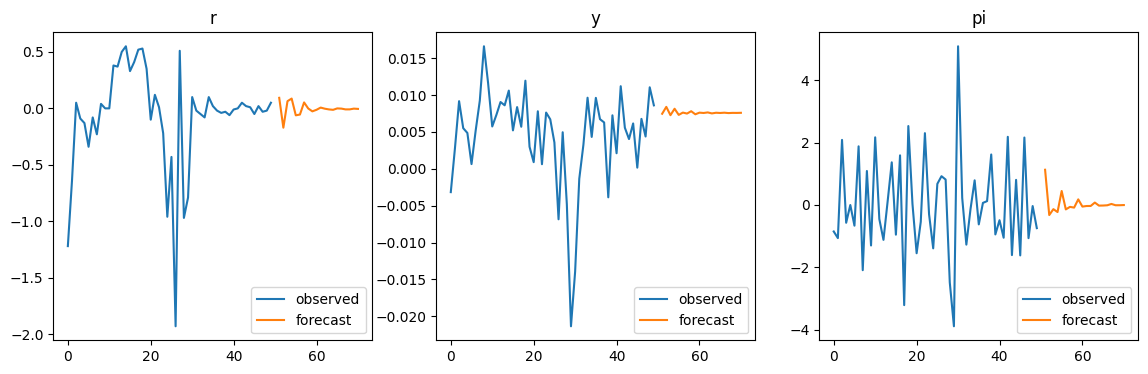

In [48]:
obs_hist = 50

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
for i in range(3):
    axs[i].plot(np.arange(obs_hist), v[-obs_hist:, i], label='observed');
    axs[i].plot(obs_hist + 1 + np.arange(fcst.shape[0]), fcst[:, i], label='forecast');
    axs[i].set_title(del_dat.columns[i]);
    axs[i].legend(loc='lower right');

#### Problem 14

In [49]:
with np_cv_rules.context():
    fit = rstats.ar(del_dat.values, order_max=1)

In [50]:
initial_v = np.expand_dims(fit['x.mean'], 0) * 1.1

In [51]:
fcst = predict(fit, initial_v, 10)
fcst[:5, :]

array([[ 0.00425171,  0.0078011 , -0.00274389],
       [-0.00396006,  0.00765268,  0.00022217],
       [-0.00529967,  0.00760137, -0.00276031],
       [-0.0052836 ,  0.00758285, -0.00157944],
       [-0.00572635,  0.00757801, -0.00211772]])

We can see that the forecast coverge to the means of each variable:

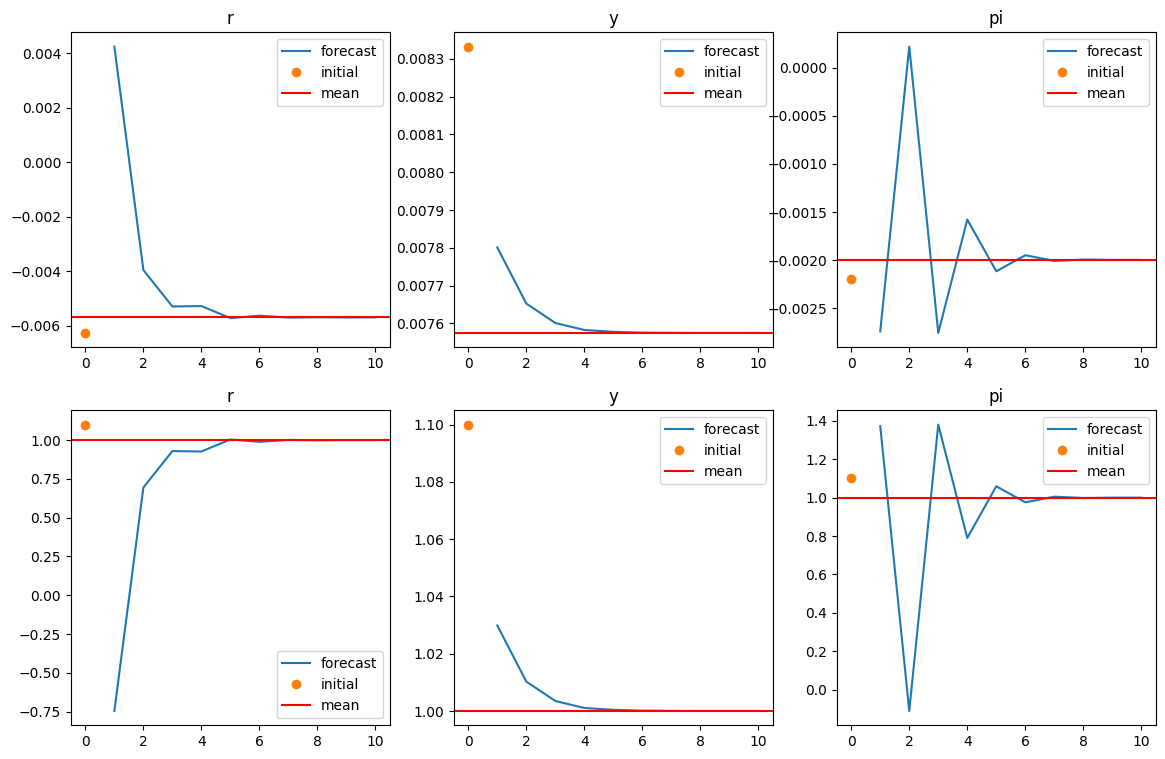

In [52]:
fig, axs = plt.subplots(2, 3, figsize=(14, 9))
for i in range(3):
    axs[0][i].plot(np.arange(1, fcst.shape[0] + 1), fcst[:, i], label='forecast');
    axs[0][i].plot([0], [initial_v[0, i]], 'o', label='initial');
    axs[0][i].axhline(fit['x.mean'][i], color='red', label='mean');
    axs[0][i].set_title(del_dat.columns[i]);
    axs[0][i].legend();
    
    axs[1][i].plot(np.arange(1, fcst.shape[0] + 1), fcst[:, i] / fit['x.mean'][i], label='forecast');
    axs[1][i].plot([0], [1.1], 'o', label='initial');
    axs[1][i].axhline(1, color='red', label='mean');
    axs[1][i].set_title(del_dat.columns[i]);
    axs[1][i].legend();

#### Problem 15

In [53]:
fit['ar']

array([[[-1.32891458e-01,  1.29957312e+01, -1.69252298e-01],
        [ 1.04769300e-03,  2.99473756e-01,  5.89146182e-04],
        [ 2.09316080e-01, -9.50664077e-01, -4.73598408e-01]]])

The values suggest that changes in $r$ are:
   * negatively correlated with preceding changes in $r$ and $pi$,
   * positively correlated with preceding changes in $y$.
    
Changes in $y$ are:
   * positively correlated with preceding changed in $r$, $y$ and $pi$.

Changed in $pi$ are:
   * positively correlated with preceding changes in $r$,
   * negatively correlated with preceding changed in $y$ and $pi$.

#### Problem 16

The absolute values of the eigenvalues are all less than 1, so the process is stationary, which agrees with the covergence to the mean we observed above:

In [54]:
np.abs(np.linalg.eig(fit['ar'])[0])

array([[0.33754099, 0.33754099, 0.33003873]])

#### Problem 17

In [55]:
data = pd.read_csv('../data/MacroVars.csv')
data.head()

,GDP251,FYFF,CPIAUCSL
0,0.025912,0.513330,0.000000
1,-0.000800,0.493330,0.003428
2,0.003593,0.413330,0.000882
3,0.021684,-0.056667,-0.005126
4,-0.004691,-0.236670,0.005084


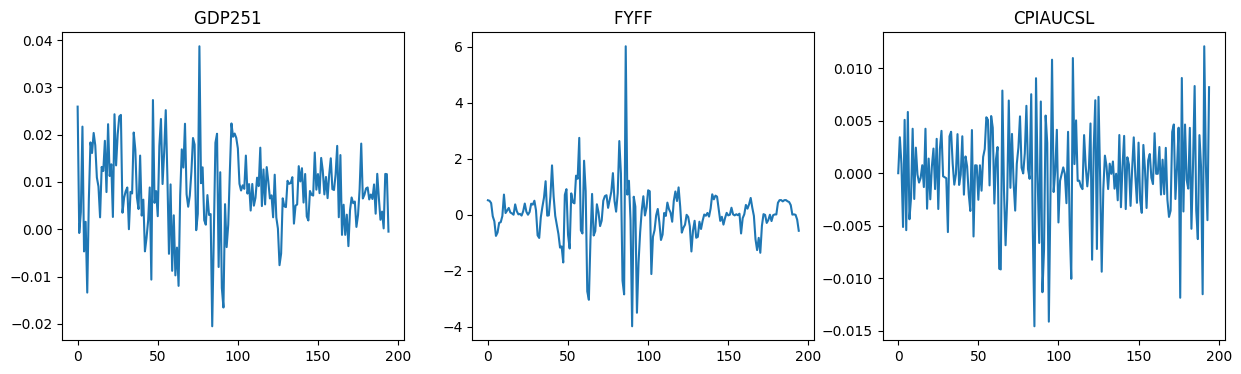

In [56]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
for i, col in enumerate(data.columns):
    axs[i].plot(data[col]);
    axs[i].set_title(col);

In [57]:
with np_cv_rules.context():
    fit = rstats.ar(data.values, order_max=15)
fit['aic']

array([139.01559335,  86.99830338,  23.56142643,  28.53430414,
        18.10265793,   0.55038666,   7.18114092,   1.31165147,
         4.27599995,   5.10049424,   0.        ,   6.64307324,
        18.68563812,  26.1843245 ,  37.03755297,  51.43348865])

In [58]:
fit['order'][0]

10

#### Problem 18

BIC selects a model with $p=2$:

In [59]:
bic = fit['aic'] + (np.log(data.shape[0] - 2)) * np.arange(0, 16) * data.shape[1] ** 2
bic

array([139.01559335, 134.36251508, 118.28984983, 170.62693924,
       207.55950474, 237.37144516, 291.36641112, 332.86113337,
       383.18969355, 431.37839954, 473.642117  , 527.64940195,
       587.05617853, 641.9190766 , 700.13651677, 761.89666415])

The optimal value of $p$ according to BIC is

In [60]:
np.argmin(bic)

2

### 13.8.5 Long-Memory Processes

In [61]:
data = pd.read_csv('../data/Mishkin.csv', usecols=list(range(1, 7)), index_col=0)
data.head()

,pai1,pai3,tb1,tb3,cpi
Year,,,,,
1950.083333,-3.552289,1.129370,1.100854,1.129406,23.5
1950.166667,5.247540,4.001566,1.125513,1.137254,23.6
1950.250000,1.692860,4.492160,1.115715,1.142319,23.6
1950.333333,5.064298,7.817513,1.146380,1.177902,23.7
1950.416667,6.719322,9.433580,1.158520,1.167777,23.8


In [62]:
diff_sqrt_cpi = np.sqrt(data['cpi']).diff().dropna()

#### Problem 19

The ACF plot suggests long memory: the autocorrelation drops to around 0.7 at lag 1 and then decays relatively slowly.

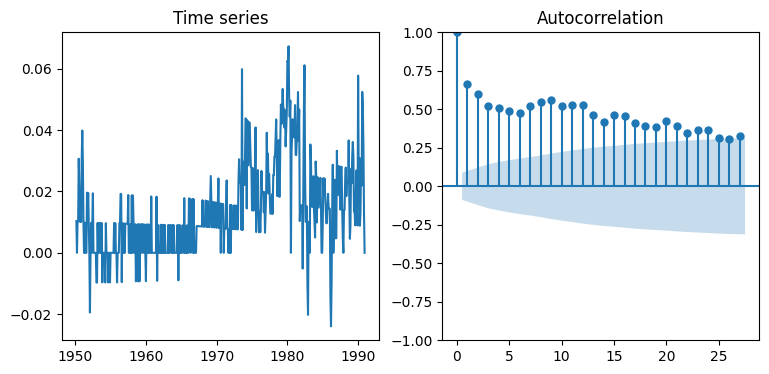

In [63]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
axs[0].plot(diff_sqrt_cpi);
axs[0].set_title('Time series');
plot_acf(diff_sqrt_cpi, ax=axs[1]);

#### Problem 20

In [64]:
with np_cv_rules.context():
    fit_frac = fracdiff.fracdiff(diff_sqrt_cpi.values, nar=0, nma=0)
fit_frac['d'][0]

0.4104047246343389

In [65]:
with np_cv_rules.context():
    fdiff = fracdiff.diffseries(diff_sqrt_cpi.values, fit_frac['d'][0])

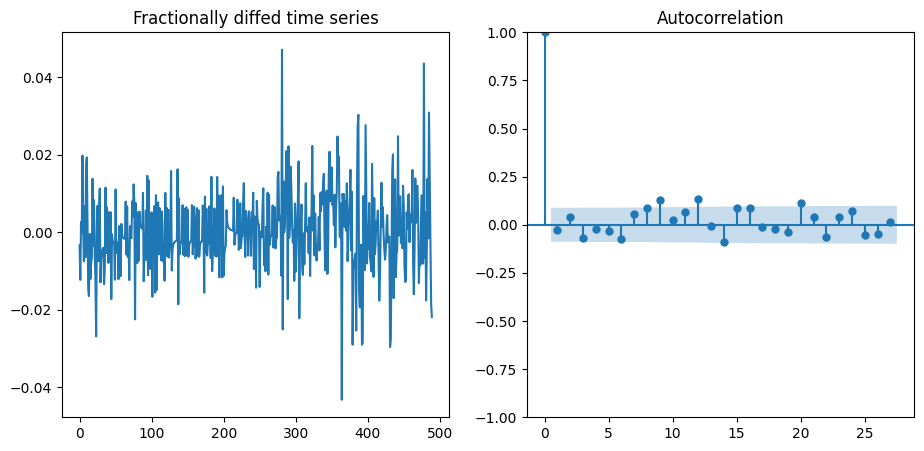

In [66]:
fig, axs = plt.subplots(1, 2, figsize=(11, 5))
axs[0].plot(fdiff);
axs[0].set_title('Fractionally diffed time series');
plot_acf(fdiff, ax=axs[1]);

There appear to be some autocorrelations remaining in the differenced time series, though the short-term and long-memory effects appear to be gone:

Using KPSS test, at 5% we reject the null hypothesis of stationarity:

In [67]:
kpss(fdiff)

(0.601649743682036,
 0.02248638693799672,
 4,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

For the diffed time series we cannot reject the null hypothesis of stationarity:

In [68]:
fd2 = np.diff(fdiff)

In [69]:
kpss(fd2)

/tmp/ipykernel_24481/3552006148.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss(fd2)


(0.18872896039451006,
 0.1,
 89,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

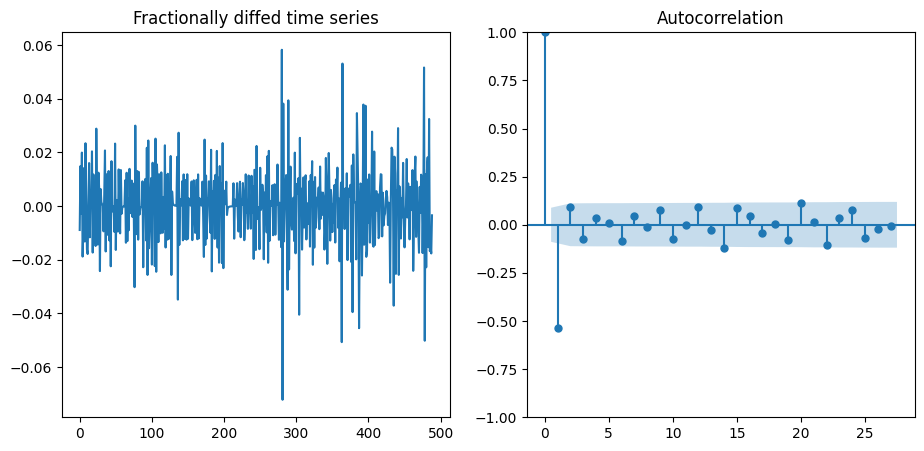

In [70]:
fig, axs = plt.subplots(1, 2, figsize=(11, 5))
axs[0].plot(fd2);
axs[0].set_title('Fractionally diffed time series');
plot_acf(fd2, ax=axs[1]);

We can see that the best model is MA(1) and has a coefficient close to -1, suggesting the original model is close to white noise:

In [71]:
pm.auto_arima(fd2, max_p=5, max_q=5, max_order=10, seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  489
Model:               SARIMAX(0, 0, 1)   Log Likelihood                1549.399
Date:                Fri, 19 May 2023   AIC                          -3094.798
Time:                        12:36:10   BIC                          -3086.413
Sample:                             0   HQIC                         -3091.505
                                - 489                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9859      0.007   -138.286      0.000      -1.000      -0.972
sigma2         0.0001   4.53e-06     22.689      0.000    9.39e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.86   Jarque-Bera (JB):               124.92
Prob(Q):                              0.35   Prob(JB):                         0.00
Heteroskedasticity (H):               2.38   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Both AIC and BIC select the MA(1) model for the differenced time series:

The same model is selected using BIC:

In [72]:
pm.auto_arima(fd2, max_p=5, max_q=5, max_order=10, seasonal=False, information_criterion='bic').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  489
Model:               SARIMAX(0, 0, 1)   Log Likelihood                1549.399
Date:                Fri, 19 May 2023   AIC                          -3094.798
Time:                        12:36:14   BIC                          -3086.413
Sample:                             0   HQIC                         -3091.505
                                - 489                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9859      0.007   -138.286      0.000      -1.000      -0.972
sigma2         0.0001   4.53e-06     22.689      0.000    9.39e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.86   Jarque-Bera (JB):               124.92
Prob(Q):                              0.35   Prob(JB):                         0.00
Heteroskedasticity (H):               2.38   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 13.8.6 Model-Based Bootstrapping of an ARIMA Process

In [73]:
data = pd.read_csv('../data/FrozenJuice.csv')
data.head()

,price,ppi,fdd
0,43.6,27.200001,0
1,52.1,27.200001,0
2,46.6,27.200001,0
3,46.6,27.200001,0
4,46.6,27.299240,0


In [74]:
price = data['price']

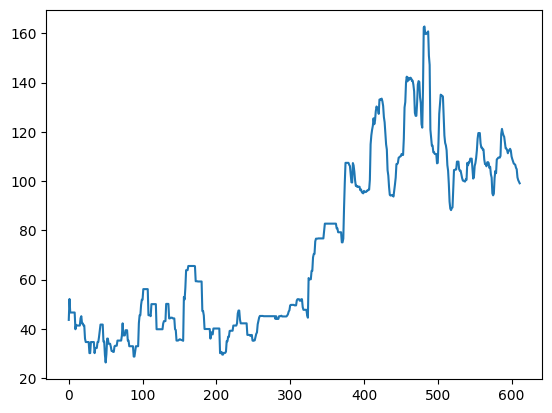

In [75]:
fig, ax = plt.subplots()
ax.plot(price);

In [76]:
fit0 = pm.auto_arima(price, information_criterion='bic')
fit0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  612
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -1571.088
Date:                Fri, 19 May 2023   AIC                           3146.176
Time:                        12:36:20   BIC                           3155.007
Sample:                             0   HQIC                          3149.611
                                - 612                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3000      0.023     13.093      0.000       0.255       0.345
sigma2        10.0206      0.220     45.517      0.000       9.589      10.452
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):              5102.14
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               1.80   Skew:                             0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [77]:
refit(fit0, price)

 ARIMA(1,1,0)(0,0,0)[0]          
 ARIMA(1,1,0)(0,0,0)[0]          
 ARIMA(1,1,0)(0,0,0)[0]          
 ARIMA(1,1,0)(0,0,0)[0]          
 ARIMA(1,1,0)(0,0,0)[0]          
 ARIMA(1,1,0)(0,0,0)[0]          
 ARIMA(0,1,1)(0,0,0)[0]          
 ARIMA(0,1,1)(0,0,0)[0]          
 ARIMA(1,1,0)(0,0,0)[0]          
 ARIMA(1,1,0)(0,0,0)[0]          


0.8

#### Problem 22

The fraction of iterations selecting the same model as above:

In [78]:
refit(fit0, price, 100, False)

0.7

#### Problem 23

In [79]:
def refit_same(niter=10):
    rng = np.random.default_rng(1998852)
    n = price.shape[0]
    burnin = 20
    phis = fit0.arparams()
    p = len(phis)
    coefs = []
    for i in range(niter):
        eps = stats.norm.rvs(size=n + burnin, scale=np.sqrt(fit0.params()['sigma2']), random_state=rng)
        y = np.zeros(n + burnin)
        for t in range(p, n + burnin):
            y[t] = np.sum(y[t-p:t] * phis) + eps[t]
        y = y[burnin:]
        y = np.cumsum(y)
        
        fit = ARIMA(y, order=fit0.order, seasonal_order=fit0.seasonal_order).fit()
        coefs.append(fit.params)
    return coefs

In [80]:
coefs = np.vstack(refit_same(10000))
coefs

array([[ 0.31799221,  9.90902469],
       [ 0.33690241,  9.96802225],
       [ 0.2890106 ,  9.95467525],
       ...,
       [ 0.28486973,  9.99948688],
       [ 0.37144981, 10.32539513],
       [ 0.29584421,  9.20348571]])

The biases of the estimates:

In [81]:
np.mean(coefs, axis=0) - fit0.params().values

array([-0.00032225, -0.01738503])

The standard deviations of estimates:

In [82]:
np.std(coefs, axis=0)

array([0.0388686 , 0.57464974])

The MSEs of estimates:

In [83]:
np.mean((coefs - fit0.params().values) ** 2, axis=0)

array([0.00151087, 0.33052457])